In [1]:
import os, re, time, json, math
import datetime
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import pandas as pd
import google
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [2]:
import tensorflow as tf
import tensorflow.keras as keras

from tf_records_generator import DatasetGenerator, count_data_items
from efficientNet_B0 import EffNet0, freeze_blocks
from log_files import save_config, save_fold_iter_history, get_log_dir, save_logs_pickle, generate_columns
from kfold import get_kfold_split, get_repeated_kfold_split
from clr_schedule import CyclicLR
from schedules import LR_test_schedule
from callbacks import CustomStopper

In [4]:
CONFIG = dict(
    log_prefix = "AUG1_",
    effnet_version = 0,
    input_shape=(256, 256, 3),
    image_resolution=256,
    trainable_base=False,
    time=datetime.datetime.now().strftime("_%d_%m_%Y_%H_%M"),
    use_patient_data=True,
    inner_blocks_frozen=3,

    upsample_ratio = 30,
    upsampling = True,

    k_fold = 3,
    kfold_repeats = 1,

    patience = 20,
    min_epochs = 32,

    lr_min=0.000003,
    lr_max=0.0001,
    lr_decay=None,
    clr_step_coefficient = 8,
    
    replicas=8,
    steps_per_epoch=None,
    validation_steps=None,
    batch_size=32,
    epochs=100,
    optimizer='adam',
    loss='binary_crossentropy',
    
    output_bias=np.log([584/32542]),
    weight_for_0 = (1 / 32542)*(32542+584)/2.0,
    weight_for_1 = (1 / 584)*(32542+584)/2.0
)

CONFIG['output_bias'] =np.log([584*CONFIG["upsample_ratio"]/32542])
CONFIG["weight_for_0"] = (1 / 32542)*(32542+584*CONFIG["upsample_ratio"])/2.0
CONFIG["weight_for_1"] = (1 / (584*CONFIG["upsample_ratio"]))*(32542+584*CONFIG["upsample_ratio"])/2.0


In [5]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  # Authenticates the Colab machine and also the TPU using your
  # credentials so that they can access your private GCS buckets.
  auth.authenticate_user()
  data_dir = 'gs://dataset_files/'
else:
  data_dir = 'dataset/'

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)
CONFIG["replicas"] = strategy.num_replicas_in_sync


INFO:tensorflow:Initializing the TPU system: grpc://10.124.195.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.195.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.124.195.186:8470']
Number of accelerators:  8


In [9]:
path = data_dir + str(CONFIG["image_resolution"])
files_train = np.sort(np.array(tf.io.gfile.glob(path + '/train*.tfrec')))
files_test = np.sort(np.array(tf.io.gfile.glob(path + '/test*.tfrec')))


In [10]:
def make_model(config:dict, strategy)    :
    with strategy.scope():
      model = EffNet0(config=config, trainable_base=config['trainable_base'])

      model.compile(optimizer=keras.optimizers.Adam(), loss=config["loss"], 
                    metrics=[
                                  keras.metrics.TruePositives(name='tp'),
                                  keras.metrics.FalsePositives(name='fp'),
                                  keras.metrics.TrueNegatives(name='tn'),
                                  keras.metrics.FalseNegatives(name='fn'), 
                                  keras.metrics.BinaryAccuracy(name='accuracy'),
                                  keras.metrics.Precision(name='precision'),
                                  keras.metrics.Recall(name='recall'),
                                  keras.metrics.AUC(name='auc'),
                            ]
    )
    return model


In [ ]:
#kfold_split = get_kfold_split(files_train,CONFIG['k_fold'])
kfold_split = get_repeated_kfold_split(files_train,CONFIG['k_fold'], CONFIG['kfold_repeats'])
save_config(CONFIG)
logs = pd.DataFrame()
log_dir = get_log_dir(CONFIG)
for iter, files in kfold_split.items():
    gener = DatasetGenerator(CONFIG)
    train_ds = gener.get_dataset(files['train'], patient_info=True,augment=True,repeat=True,upsampling=True) 
    val_ds = gener.get_dataset(files['validation'], patient_info=True,repeat=True)
    #if CONFIG['steps_per_epoch'] is None:
    CONFIG['steps_per_epoch'] = math.ceil(count_data_items(files["train"])*(0.982+0.018*CONFIG["upsample_ratio"])/(CONFIG["batch_size"]*CONFIG["replicas"]))
    if CONFIG['validation_steps'] is None:
        CONFIG['validation_steps'] = math.ceil(count_data_items(files["validation"])/(CONFIG["batch_size"]*CONFIG["replicas"]))

    clr = CyclicLR(base_lr=CONFIG["lr_min"], max_lr=CONFIG["lr_max"],
                                step_size=CONFIG['steps_per_epoch']*CONFIG['clr_step_coefficient'], mode='triangular')
    stopper = CustomStopper(monitor='val_auc',patience=CONFIG['patience'],start_epoch=CONFIG['min_epochs'])

    tb_callback = keras.callbacks.TensorBoard(log_dir=os.path.join(log_dir,f"tb_{iter}"))
    model = make_model(CONFIG, strategy=strategy)
    history = model.fit(train_ds,class_weight={0:CONFIG["weight_for_0"],1:CONFIG["weight_for_1"]},
                        validation_data=val_ds,validation_batch_size=CONFIG["batch_size"]*CONFIG["replicas"],
                        batch_size=CONFIG["batch_size"]*CONFIG["replicas"], epochs=CONFIG["epochs"],
                        steps_per_epoch=CONFIG['steps_per_epoch'],validation_steps=CONFIG['validation_steps'],
                        callbacks=[clr,stopper])
    
    if logs.empty:
        logs = generate_columns(logs,history.history)
    logs = logs.append(history.history, ignore_index=True)
    
save_logs_pickle(logs,CONFIG)


zip_name = os.path.basename(log_dir) + '.zip'
!zip -r $zip_name $log_dir

zip_name = os.path.join("/content/gdrive/My Drive",zip_name)
!zip -r "$zip_name" $log_dir


Epoch 1/100
  2/130 [..............................] - ETA: 9s - loss: 0.8842 - tp: 46.0000 - fp: 102.0000 - tn: 223.0000 - fn: 141.0000 - accuracy: 0.5254 - precision: 0.3108 - recall: 0.2460 - auc: 0.4709WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0117s vs `on_train_batch_end` time: 0.1121s). Check your callbacks.


130/130 [==============================] - ETA: 0s - loss: 0.7203 - tp: 5320.0000 - fp: 6419.0000 - tn: 15264.0000 - fn: 6277.0000 - accuracy: 0.6185 - precision: 0.4532 - recall: 0.4587 - auc: 0.6298WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0057s vs `on_test_batch_end` time: 0.0559s). Check your callbacks.


130/130 [==============================] - 34s 261ms/step - loss: 0.7203 - tp: 5320.0000 - fp: 6419.0000 - tn: 15264.0000 - fn: 6277.0000 - accuracy: 0.6185 - precision: 0.4532 - recall: 0.4587 - auc: 0.6298 - val_loss: 0.1051 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 10807.0000 - val_fn: 200.0000 - val_accuracy: 0.9817 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6332
Epoch 2/100
130/130 [==============================] - 23s 179ms/step - loss: 0.6250 - tp: 7737.0000 - fp: 7482.0000 - tn: 14154.0000 - fn: 3907.0000 - accuracy: 0.6578 - precision: 0.5084 - recall: 0.6645 - auc: 0.7254 - val_loss: 0.2748 - val_tp: 9.0000 - val_fp: 202.0000 - val_tn: 10623.0000 - val_fn: 174.0000 - val_accuracy: 0.9658 - val_precision: 0.0427 - val_recall: 0.0492 - val_auc: 0.6619
Epoch 3/100
130/130 [==============================] - 24s 183ms/step - loss: 0.6032 - tp: 8331.0000 - fp: 7530.0000 - tn: 13894.0000 - fn: 3525.0000 - accuracy: 0.6678 - precision: 0.5253 - recall: 0

In [ ]:
print("jacek")

In [ ]:
log_dir = get_log_dir(CONFIG)
zip_name = os.path.basename(log_dir) + '.zip'
!zip -r $zip_name $log_dir

0.8280553619066874

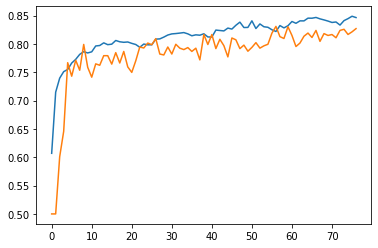

In [17]:
i = 2
plt.plot(logs['auc'][i])
plt.plot(logs['val_auc'][i])
suma = 0
for k in [0,1,2]:
 suma += np.max(logs['val_auc'][k])
suma/3
#np.max(logs['val_auc'][i])